In [7]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Auto select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------------------------------
# Load metadata
# ---------------------------------------------------
with open("/kaggle/input/cub2002011/CUB_200_2011/train_test_split.txt") as f:
    split = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/images.txt") as f:
    paths = dict(line.strip().split() for line in f)

with open("/kaggle/input/cub2002011/CUB_200_2011/image_class_labels.txt") as f:
    labels = dict(line.strip().split() for line in f)

# ---------------------------------------------------
# Select only FIRST 5 classes
# ---------------------------------------------------
selected_classes = set(list({int(v) for v in labels.values()})[:200])

print("Using classes:", selected_classes)

train_paths, train_labels = [], []
test_paths, test_labels = [], []

base = "/kaggle/input/cub2002011/CUB_200_2011/images/"

for img_id, rel in paths.items():
    cls = int(labels[img_id])
    if cls not in selected_classes:
        continue

    full = base + rel
    if split[img_id] == "1":
        train_paths.append(full)
        train_labels.append(cls)
    else:
        test_paths.append(full)
        test_labels.append(cls)

print("Train images:", len(train_paths))
print("Test images :", len(test_paths))

# ---------------------------------------------------
# Convert to DataFrames (path + class)
# ---------------------------------------------------
train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

# ---------------------------------------------------
# Per-class sample counts
# ---------------------------------------------------

train_count = train_df["class"].value_counts().sort_index()
test_count  = test_df["class"].value_counts().sort_index()

print("\n===== TRAIN PER-CLASS COUNTS =====")
print(train_count)

print("\n===== TEST PER-CLASS COUNTS =====")
print(test_count)

print("\n===== SUMMARY =====")
print("Train: classes =", train_count.index.nunique(),
      "| min =", train_count.min(),
      "| max =", train_count.max(),
      "| avg =", train_count.mean())

print("Test : classes =", test_count.index.nunique(),
      "| min =", test_count.min(),
      "| max =", test_count.max(),
      "| avg =", test_count.mean())

# ---------------------------------------------------
# Dataset class with transforms
# ---------------------------------------------------
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        cls = self.labels[idx] - 1
        return img, cls

# ---------------------------------------------------
# Dataloaders
# ---------------------------------------------------
train_dataset = CUBDataset(train_df, transform_train)
test_dataset = CUBDataset(test_df, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset , batch_size=32, shuffle=False, num_workers=2)

print("Train loader batches:", len(train_loader))
print("Test loader batches :", len(test_loader))

Using device: cuda
Using classes: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200}
Train images: 5994
Test images : 5794

===== TRAIN PER-CLASS COUNTS =====

Using device: cuda
PyTorch: 2.6.0+cu124
Train (known): 3000 imgs, 100 classes
Test  (unseen): 2930 imgs, 100 classes
Epoch 01 | Loss: 4.9575 | Val R@1: 0.2633
Epoch 02 | Loss: 3.5733 | Val R@1: 0.3233
Epoch 03 | Loss: 2.5063 | Val R@1: 0.3667
Epoch 04 | Loss: 1.8658 | Val R@1: 0.3867
Epoch 05 | Loss: 1.4480 | Val R@1: 0.4200
Epoch 06 | Loss: 1.1704 | Val R@1: 0.4800
Epoch 07 | Loss: 0.9733 | Val R@1: 0.5000
Epoch 08 | Loss: 0.8281 | Val R@1: 0.5067
Epoch 09 | Loss: 0.7002 | Val R@1: 0.5300
Epoch 10 | Loss: 0.6163 | Val R@1: 0.5433
Epoch 11 | Loss: 0.5433 | Val R@1: 0.5567
Epoch 12 | Loss: 0.4890 | Val R@1: 0.5700
Epoch 13 | Loss: 0.4292 | Val R@1: 0.5667
Epoch 14 | Loss: 0.3905 | Val R@1: 0.5433
Epoch 15 | Loss: 0.3552 | Val R@1: 0.5733
Epoch 16 | Loss: 0.3282 | Val R@1: 0.5767
Epoch 17 | Loss: 0.2924 | Val R@1: 0.5933
Epoch 18 | Loss: 0.2676 | Val R@1: 0.6033
Epoch 19 | Loss: 0.2480 | Val R@1: 0.5933
Epoch 20 | Loss: 0.2285 | Val R@1: 0.5933
Epoch 21 | Loss: 0.2110 | Val R@1: 0.5833
E

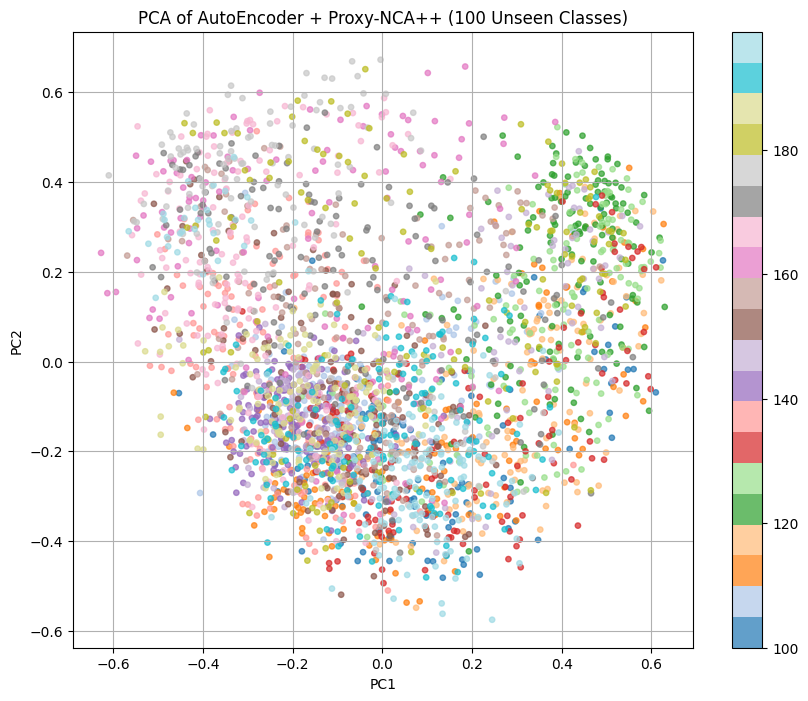

In [8]:
# --------------------------------------------------------------
# 1. Imports & Device
# --------------------------------------------------------------
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, pairwise_distances
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("PyTorch:", torch.__version__)

# --------------------------------------------------------------
# 2. Seed
# --------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

# --------------------------------------------------------------
# 3. Load CUB metadata
# --------------------------------------------------------------
base_dir = "/kaggle/input/cub2002011/CUB_200_2011"

with open(os.path.join(base_dir, "train_test_split.txt")) as f:
    split_dict = {k: int(v) for k, v in (l.strip().split() for l in f)}
with open(os.path.join(base_dir, "images.txt")) as f:
    path_dict = dict(l.strip().split() for l in f)
with open(os.path.join(base_dir, "image_class_labels.txt")) as f:
    label_dict = dict(l.strip().split() for l in f)

# --------------------------------------------------------------
# 4. Zero-shot split: first 100 train, last 100 test
# --------------------------------------------------------------
all_classes = sorted({int(v) for v in label_dict.values()})
train_classes = set(all_classes[:100])
test_classes  = set(all_classes[100:200])

train_paths, train_labels = [], []
test_paths , test_labels  = [], []

img_base = os.path.join(base_dir, "images")
for img_id, rel in path_dict.items():
    cls = int(label_dict[img_id])
    if cls not in train_classes and cls not in test_classes: continue
    full = os.path.join(img_base, rel)
    is_train = split_dict[img_id] == 1

    if cls in train_classes and is_train:
        train_paths.append(full); train_labels.append(cls-1)
    elif cls in test_classes and not is_train:
        test_paths.append(full); test_labels.append(cls-1)

train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

print(f"Train (known): {len(train_df)} imgs, {len(train_classes)} classes")
print(f"Test  (unseen): {len(test_df)} imgs, {len(test_classes)} classes")

# --------------------------------------------------------------
# 5. Transforms
# --------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        return img, self.labels[idx]

batch_size = 128
train_loader = DataLoader(CUBDataset(train_df, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
test_loader  = DataLoader(CUBDataset(test_df, test_transform),
                          batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

# --------------------------------------------------------------
# 6. Simple AutoEncoder Model
# --------------------------------------------------------------
class SimpleMetricAutoEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        goog = models.googlenet(weights="IMAGENET1K_V1")
        self.backbone = nn.Sequential(
            goog.conv1, goog.maxpool1,
            goog.conv2, goog.conv3, goog.maxpool2,
            goog.inception3a, goog.inception3b, goog.maxpool3,
            goog.inception4a, goog.inception4b, goog.inception4c,
            goog.inception4d, goog.inception4e,
            goog.maxpool4,
            goog.inception5a, goog.inception5b,
            goog.avgpool
        )
        self.fc_embed = nn.Linear(1024, embed_dim)
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def extract_f(self, x):
        f = self.backbone(x)
        return f.view(f.size(0), -1)          # (B, 1024)

    def forward(self, x):
        f = self.extract_f(x)
        z = self.fc_embed(f)
        f_hat = self.decoder(z)
        return z, f, f_hat

# --------------------------------------------------------------
# 7. Proxy-NCA++ Loss (Multiple Positive Proxies)
# --------------------------------------------------------------
class ProxyNCAPlusPlus(nn.Module):
    def __init__(self, embed_dim, num_classes, num_pos=3, temp=0.1):
        super().__init__()
        self.proxies = nn.Parameter(torch.randn(num_classes, num_pos, embed_dim))
        nn.init.xavier_uniform_(self.proxies)
        self.temp = temp
        self.num_pos = num_pos

    def forward(self, embedding, label):
        embedding = F.normalize(embedding, dim=1)          # (B, D)
        proxies   = F.normalize(self.proxies, dim=-1)     # (C, K, D)

        B, D = embedding.shape
        C, K = proxies.shape[:2]

        label_exp = label.unsqueeze(1).expand(B, K)       # (B, K)
        pos_proxies = proxies[label_exp, torch.arange(K).to(device)]

        sim_pos = torch.bmm(pos_proxies, embedding.unsqueeze(-1)).squeeze(-1) / self.temp
        sim_pos = sim_pos.max(dim=1)[0]                   # (B,)

        all_proxies = proxies.view(-1, D)                 # (C*K, D)
        sim_all = F.linear(embedding, all_proxies) / self.temp
        logsumexp = torch.logsumexp(sim_all, dim=1)

        loss = -(sim_pos - logsumexp).mean()
        return loss

# --------------------------------------------------------------
# 8. Loss Helper
# --------------------------------------------------------------
def recon_loss(f, f_hat):
    return F.mse_loss(f_hat, f)

# --------------------------------------------------------------
# 9. EVALUATION METRICS (MUST BE DEFINED BEFORE TRAINING)
# --------------------------------------------------------------
def recall_at_k(E, L, k=1):
    sim = E @ E.T
    np.fill_diagonal(sim, -np.inf)
    idx = np.argpartition(-sim, k, axis=1)[:, :k]
    correct = sum(L[i] in L[idx[i]] for i in range(len(L)))
    return correct / len(L)

def clustering_metrics(E, L, n_clusters):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    pred = km.fit_predict(E)
    nmi = normalized_mutual_info_score(L, pred)
    f1  = f1_score(L, pred, average='macro')
    return nmi, f1

def pairwise_prec_recall(E, L):
    D = pairwise_distances(E)
    y_true = (L[:, None] == L[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D <= thr).astype(int)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    return prec, rec

# --------------------------------------------------------------
# 10. Model & Optimizer
# --------------------------------------------------------------
embed_dim   = 128
num_classes = 100                     # only known classes

model     = SimpleMetricAutoEncoder(embed_dim=embed_dim).to(device)
proxy_nca = ProxyNCAPlusPlus(embed_dim, num_classes, num_pos=3, temp=0.1).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(proxy_nca.parameters()),
    lr=1e-4,
    weight_decay=1e-5
)

# --------------------------------------------------------------
# 11. Validation split (for early-stop)
# --------------------------------------------------------------
val_ratio = 0.1
val_df_list = []
train_df_list = []
for c in range(100):
    sub = train_df[train_df["class"] == c]
    n_val = max(1, int(len(sub) * val_ratio))
    idx = np.random.choice(sub.index, n_val, replace=False)
    val_df_list.append(sub.loc[idx])
    train_df_list.append(sub.drop(idx))

val_df       = pd.concat(val_df_list).reset_index(drop=True)
train_df_fin = pd.concat(train_df_list).reset_index(drop=True)

train_loader = DataLoader(CUBDataset(train_df_fin, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
val_loader   = DataLoader(CUBDataset(val_df, test_transform),
                          batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

# --------------------------------------------------------------
# 12. Validation helper (uses recall_at_k defined above)
# --------------------------------------------------------------
@torch.no_grad()
def validate():
    model.eval()
    E, L = [], []
    for x, y in val_loader:
        x = x.to(device)
        z, _, _ = model(x)
        E.append(z.cpu())
        L.append(y)
    E = torch.cat(E)
    L = torch.cat(L)
    E = F.normalize(E, dim=1).numpy()
    L = L.numpy()
    return recall_at_k(E, L, k=1)

# --------------------------------------------------------------
# 13. Training Loop
# --------------------------------------------------------------
EPOCHS   = 100
λ_recon  = 1.0
λ_nca    = 1.0

best_val_r1 = 0.0
patience    = 15
wait        = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    proxy_nca.train()
    epoch_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        z, f, f_hat = model(imgs)
        L_rec = recon_loss(f, f_hat)
        L_nca = proxy_nca(z, labels)

        loss = λ_recon * L_rec + λ_nca * L_nca

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # ------------------- validation -------------------
    val_r1 = validate()
    print(f"Epoch {epoch:02d} | Loss: {epoch_loss/len(train_loader):.4f} | Val R@1: {val_r1:.4f}")

    if val_r1 > best_val_r1:
        best_val_r1 = val_r1
        torch.save(model.state_dict(), "ae_proxy_best.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping!")
            break

# Load best checkpoint
model.load_state_dict(torch.load("ae_proxy_best.pth"))

# --------------------------------------------------------------
# 14. Feature extraction helper
# --------------------------------------------------------------
@torch.no_grad()
def extract_feats(loader):
    model.eval()
    embs, lbls = [], []
    for x, y in loader:
        x = x.to(device)
        z, _, _ = model(x)
        embs.append(z.cpu())
        lbls.append(y)
    E = torch.cat(embs)
    L = torch.cat(lbls)
    E = F.normalize(E, dim=1).numpy()
    L = L.numpy()
    return E, L

# --------------------------------------------------------------
# 15. TRAIN SET evaluation
# --------------------------------------------------------------
print("\n" + "="*60)
print("EVALUATION ON TRAIN SET (100 known classes)")
print("="*60)
train_E, train_L = extract_feats(train_loader)
for k in [1,2,4,8]:
    print(f"Recall@{k}: {recall_at_k(train_E, train_L, k):.4f}")
nmi_tr, f1_tr = clustering_metrics(train_E, train_L, n_clusters=100)
print(f"NMI : {nmi_tr:.4f}")
print(f"F1  : {f1_tr:.4f}")
p_tr, r_tr = pairwise_prec_recall(train_E, train_L)
print(f"Prec: {p_tr:.4f}  Rec: {r_tr:.4f}")

# --------------------------------------------------------------
# 16. TEST SET evaluation
# --------------------------------------------------------------
print("\n" + "="*60)
print("EVALUATION ON TEST SET (100 unseen classes)")
print("="*60)
test_E, test_L = extract_feats(test_loader)
for k in [1,2,4,8]:
    print(f"Recall@{k}: {recall_at_k(test_E, test_L, k):.4f}")
nmi_te, f1_te = clustering_metrics(test_E, test_L, n_clusters=100)
print(f"NMI : {nmi_te:.4f}")
print(f"F1  : {f1_te:.4f}")
p_te, r_te = pairwise_prec_recall(test_E, test_L)
print(f"Prec: {p_te:.4f}  Rec: {r_te:.4f}")

# --------------------------------------------------------------
# 17. PCA visualisation (test)
# --------------------------------------------------------------
def plot_pca(E, L, title="PCA", n_samples=3000):
    if len(E) > n_samples:
        idx = np.random.choice(len(E), n_samples, replace=False)
        E, L = E[idx], L[idx]
    X = PCA(n_components=2).fit_transform(E)
    plt.figure(figsize=(10, 8))
    s = plt.scatter(X[:,0], X[:,1], c=L, cmap='tab20', s=15, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.colorbar(s)
    plt.grid(True)
    plt.show()

plot_pca(test_E, test_L, "PCA of AutoEncoder + Proxy-NCA++ (100 Unseen Classes)")

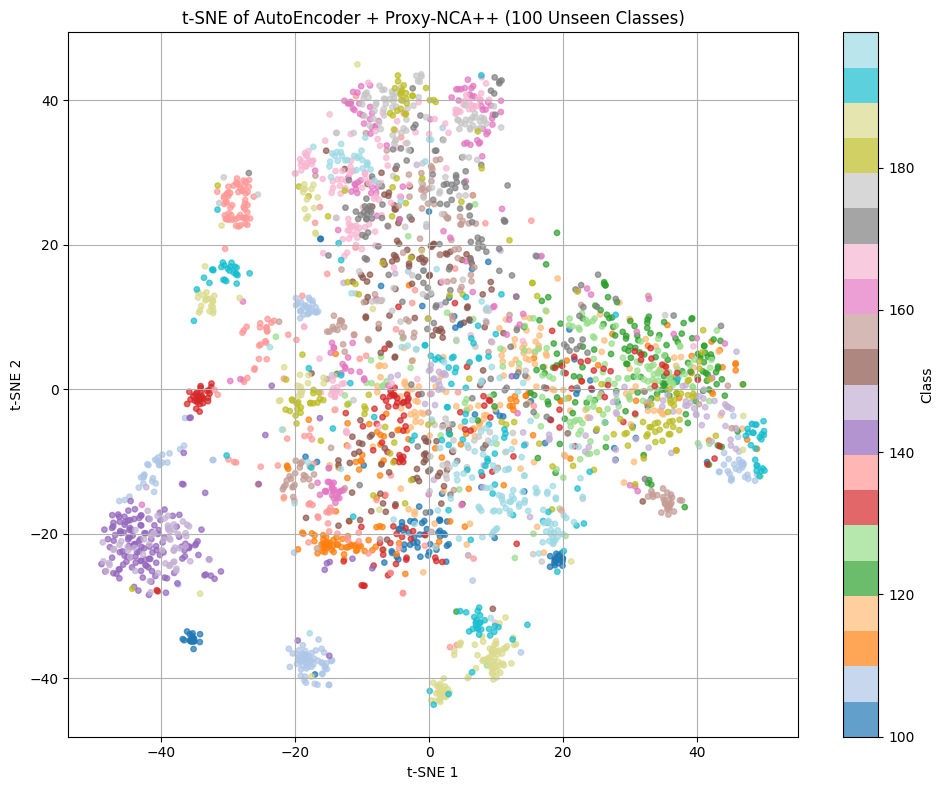

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(E, L, title="t-SNE", n_samples=3000, perplexity=30, random_state=42):
    """
    Visualise embeddings E with labels L using t-SNE.
    
    Parameters
    ----------
    E : np.ndarray, shape (N, D)
        Embedding matrix.
    L : np.ndarray, shape (N,)
        Integer class labels.
    title : str
        Plot title.
    n_samples : int
        If N > n_samples, randomly subsample.
    perplexity : float
        t-SNE perplexity (typical values 5-50).
    random_state : int
        For reproducibility.
    """
    if len(E) > n_samples:
        idx = np.random.choice(len(E), n_samples, replace=False)
        E, L = E[idx], L[idx]

    # t-SNE (Barnes-Hut, O(N log N))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        random_state=random_state,
        method='barnes_hut',   # fast approximate version
        n_jobs=-1
    )
    X_2d = tsne.fit_transform(E)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=L, cmap='tab20', s=15, alpha=0.7
    )
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(scatter, label='Class')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------
# Example usage (exactly like your PCA call)
# ------------------------------------------------------------------
plot_tsne(
    test_E, test_L,
    title="t-SNE of AutoEncoder + Proxy-NCA++ (100 Unseen Classes)",
    n_samples=3000,
    perplexity=40          # tweak 20-50 for 100 classes
)

Using device: cuda
Train (known): 3000 imgs, 100 classes
Test  (unseen): 2930 imgs, 100 classes
Train (after val split): 2600
Val   (known): 400
Epoch 001 | Phase 1 | Loss 5.3610 | Val NMI 0.7709
Epoch 002 | Phase 1 | Loss 4.8354 | Val NMI 0.7784
Epoch 003 | Phase 1 | Loss 4.2873 | Val NMI 0.7887
Epoch 004 | Phase 1 | Loss 3.8604 | Val NMI 0.7922
Epoch 005 | Phase 1 | Loss 3.5563 | Val NMI 0.8006
Epoch 006 | Phase 1 | Loss 3.2743 | Val NMI 0.8188
Epoch 007 | Phase 1 | Loss 3.0595 | Val NMI 0.8271
Epoch 008 | Phase 1 | Loss 2.8579 | Val NMI 0.8223
Epoch 009 | Phase 1 | Loss 2.7114 | Val NMI 0.8406
Epoch 010 | Phase 1 | Loss 2.5548 | Val NMI 0.8495
Epoch 011 | Phase 1 | Loss 2.4057 | Val NMI 0.8535
Epoch 012 | Phase 1 | Loss 2.3079 | Val NMI 0.8582
Epoch 013 | Phase 1 | Loss 2.1947 | Val NMI 0.8725
Epoch 014 | Phase 1 | Loss 2.1021 | Val NMI 0.8634
Epoch 015 | Phase 1 | Loss 2.0463 | Val NMI 0.8624
Epoch 016 | Phase 1 | Loss 1.9587 | Val NMI 0.8673
Epoch 017 | Phase 1 | Loss 1.8808 | Val

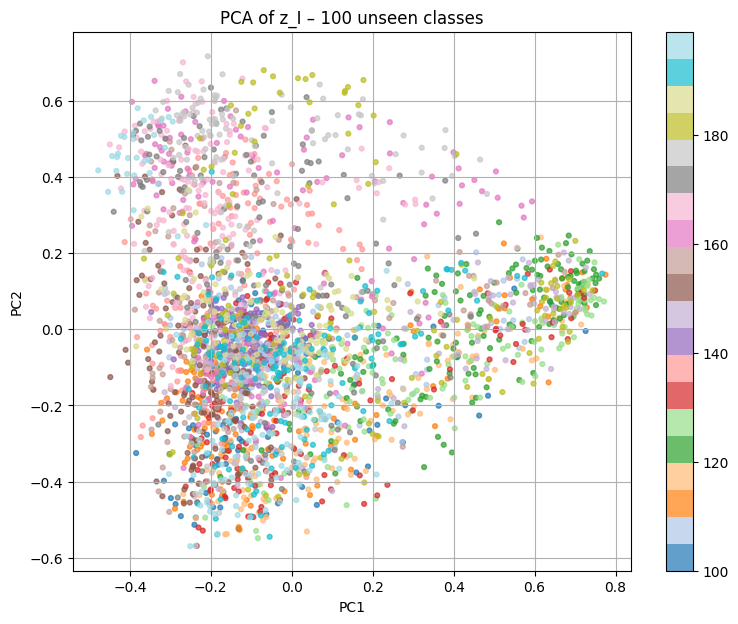

In [10]:
# --------------------------------------------------------------
# 1. Imports & device
# --------------------------------------------------------------
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, f1_score, pairwise_distances
from sklearn.decomposition import PCA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------------------
# 2. Seed everything
# --------------------------------------------------------------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --------------------------------------------------------------
# 3. Load CUB metadata
# --------------------------------------------------------------
base_dir = "/kaggle/input/cub2002011/CUB_200_2011"

with open(os.path.join(base_dir, "train_test_split.txt")) as f:
    split_dict = {k: int(v) for k, v in (l.strip().split() for l in f)}
with open(os.path.join(base_dir, "images.txt")) as f:
    path_dict = dict(l.strip().split() for l in f)
with open(os.path.join(base_dir, "image_class_labels.txt")) as f:
    label_dict = dict(l.strip().split() for l in f)

# --------------------------------------------------------------
# 4. Zero-shot split (first 100 = train, last 100 = test)
# --------------------------------------------------------------
all_classes = sorted({int(v) for v in label_dict.values()})
train_classes = set(all_classes[:100])   # known
test_classes  = set(all_classes[100:200])# unseen

train_paths, train_labels = [], []
test_paths , test_labels  = [], []

img_base = os.path.join(base_dir, "images")
for img_id, rel in path_dict.items():
    cls = int(label_dict[img_id])
    if cls not in train_classes and cls not in test_classes:
        continue
    full = os.path.join(img_base, rel)
    is_train = split_dict[img_id] == 1

    if cls in train_classes and is_train:
        train_paths.append(full); train_labels.append(cls-1)
    elif cls in test_classes and not is_train:
        test_paths.append(full); test_labels.append(cls-1)

train_df = pd.DataFrame({"path": train_paths, "class": train_labels})
test_df  = pd.DataFrame({"path": test_paths , "class": test_labels})

print(f"Train (known): {len(train_df)} imgs, {len(train_classes)} classes")
print(f"Test  (unseen): {len(test_df)} imgs, {len(test_classes)} classes")

# --------------------------------------------------------------
# 5. Validation split from *known* classes (for early-stop)
# --------------------------------------------------------------
val_ratio = 0.15
val_df_list = []
train_df_list = []

for c in train_classes:
    sub = train_df[train_df["class"] == c-1]
    n_val = max(1, int(len(sub) * val_ratio))
    val_idx = np.random.choice(sub.index, n_val, replace=False)
    val_df_list.append(sub.loc[val_idx])
    train_df_list.append(sub.drop(val_idx))

val_df  = pd.concat(val_df_list).reset_index(drop=True)
train_df = pd.concat(train_df_list).reset_index(drop=True)

print(f"Train (after val split): {len(train_df)}")
print(f"Val   (known): {len(val_df)}")

# --------------------------------------------------------------
# 6. Transforms (paper exact)
# --------------------------------------------------------------
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

test_transform = val_transform  # same as val

class CUBDataset(Dataset):
    def __init__(self, df, transform):
        self.paths = df["path"].values
        self.labels = df["class"].values
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transform(img)
        return img, self.labels[idx]

batch_size = 128
train_loader = DataLoader(CUBDataset(train_df, train_transform),
                          batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True, drop_last=True)
val_loader   = DataLoader(CUBDataset(val_df , val_transform),
                          batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)
test_loader  = DataLoader(CUBDataset(test_df, test_transform),
                          batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

# --------------------------------------------------------------
# 7. DVML model (exact architecture)
# --------------------------------------------------------------
class DVML(nn.Module):
    def __init__(self, embed_dim=512, T=20, dropout=0.3):
        super().__init__()
        goog = models.googlenet(weights="IMAGENET1K_V1")
        # keep everything up to avg-pool (1024-d)
        self.backbone = nn.Sequential(*list(goog.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1,1))

        self.fc_I     = nn.Sequential(nn.Linear(1024, embed_dim), nn.Dropout(dropout))
        self.fc_mu    = nn.Sequential(nn.Linear(1024, embed_dim), nn.Dropout(dropout))
        self.fc_logvar= nn.Sequential(nn.Linear(1024, embed_dim), nn.Dropout(dropout))

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, 512),
            nn.Tanh(),
            nn.Linear(512, 1024)
        )
        self.T = T
        self.embed_dim = embed_dim

    def encode(self, x):
        f = self.pool(self.backbone(x)).view(x.size(0), -1)   # (B,1024)
        z_I = self.fc_I(f)
        mu  = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return z_I, mu, logvar, f

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, phase=2):
        z_I, mu, logvar, f = self.encode(x)
        z_V = self.reparameterize(mu, logvar)               # (B,D)

        # ---- T synthetic samples ----
        z_V = z_V.unsqueeze(1).repeat(1, self.T, 1)          # (B,T,D)
        z_I_rep = z_I.unsqueeze(1).repeat(1, self.T, 1)
        z_hat = z_I_rep + z_V                               # (B,T,D)

        z_hat_flat = z_hat.view(-1, self.embed_dim)         # (B*T,D)
        f_hat_flat = self.decoder(z_hat_flat)               # (B*T,1024)

        if phase == 1:                                      # stop decoder grads
            f_hat_flat = f_hat_flat.detach()

        return z_I, f, f_hat_flat, z_hat_flat, mu, logvar, z_hat

# --------------------------------------------------------------
# 8. Proxy-NCA with label-smoothing & L2 on proxies
# --------------------------------------------------------------
class ProxyNCA(nn.Module):
    def __init__(self, embed_dim, n_classes, temp=0.1, label_smoothing=0.1, proxy_l2=1e-4):
        super().__init__()
        self.proxies = nn.Parameter(torch.randn(n_classes, embed_dim))
        nn.init.xavier_uniform_(self.proxies)
        self.temp = temp
        self.ls   = label_smoothing
        self.l2   = proxy_l2

    def forward(self, emb, label):
        emb = F.normalize(emb, dim=1)
        prox = F.normalize(self.proxies, dim=1)

        sim = F.linear(emb, prox) / self.temp                # (B,C)

        # label-smoothing
        target = F.one_hot(label, num_classes=prox.size(0)).float()
        target = target * (1-self.ls) + (self.ls / prox.size(0))

        log_prob = F.log_softmax(sim, dim=1)
        loss = - (target * log_prob).sum(dim=1).mean()

        # L2 regularisation on proxies
        if self.l2 > 0:
            loss = loss + self.l2 * (prox ** 2).sum()
        return loss

# --------------------------------------------------------------
# 9. Loss helpers
# --------------------------------------------------------------
def kl_divergence(mu, logvar):
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

def recon_loss(f, f_hat_flat, T):
    f_rep = f.repeat(T, 1)
    return F.mse_loss(f_hat_flat, f_rep)

# --------------------------------------------------------------
# 10. Model / optimiser
# --------------------------------------------------------------
embed_dim = 512
T = 20
num_classes = len(train_classes)          # 100 known

model       = DVML(embed_dim=embed_dim, T=T, dropout=0.3).to(device)
proxy_I     = ProxyNCA(embed_dim, num_classes, temp=0.1,
                       label_smoothing=0.1, proxy_l2=1e-4).to(device)
proxy_hat   = ProxyNCA(embed_dim, num_classes, temp=0.1,
                       label_smoothing=0.1, proxy_l2=1e-4).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(proxy_I.parameters()) + list(proxy_hat.parameters()),
    lr=1e-4, weight_decay=1e-5
)

# --------------------------------------------------------------
# 11. KL annealing schedule
# --------------------------------------------------------------
total_epochs = 120
warmup_epochs = 30
kl_start = 0.0
kl_end   = 1.0

def get_kl_weight(epoch):
    if epoch <= warmup_epochs:
        return kl_start + (kl_end - kl_start) * (epoch / warmup_epochs)
    return kl_end

# --------------------------------------------------------------
# 13. Feature extraction helper
# --------------------------------------------------------------
@torch.no_grad()
def extract_feats(loader):
    model.eval()
    embs, lbls = [], []
    for imgs, ls in loader:
        imgs = imgs.to(device)
        z_I, *_ = model(imgs, phase=2)
        embs.append(z_I.cpu())
        lbls.append(ls)
    E = torch.cat(embs)
    L = torch.cat(lbls)
    E = F.normalize(E, dim=1).numpy()
    L = L.numpy()
    return E, L
    
# --------------------------------------------------------------
# 14. Evaluation metrics
# --------------------------------------------------------------
def recall_at_k(feats, labels, k):
    sim = feats @ feats.T
    np.fill_diagonal(sim, -np.inf)
    idx = np.argpartition(-sim, k, axis=1)[:, :k]
    correct = 0
    for i, neigh in enumerate(idx):
        if labels[i] in labels[neigh]:
            correct += 1
    return correct / len(labels)

def clustering_metrics(feats, labels, n_clusters):
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=0)
    pred = km.fit_predict(feats)
    nmi = normalized_mutual_info_score(labels, pred)
    f1  = f1_score(labels, pred, average='macro')
    return nmi, f1

def pairwise_prec_recall(feats, labels):
    D = pairwise_distances(feats, metric='euclidean')
    y_true = (labels[:, None] == labels[None, :]).astype(int)
    thr = np.median(D)
    y_pred = (D <= thr).astype(int)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1-y_true)).sum()
    fn = ((1-y_pred) * y_true).sum()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    return prec, rec
# --------------------------------------------------------------
# 12. Training loop (two phases + early-stop)
# --------------------------------------------------------------
phase1_epochs = 60
phase2_epochs = total_epochs - phase1_epochs

best_val_nmi = 0.0
patience = 20
wait = 0

# loss weights (paper)
λ1_p1, λ2_p1, λ3_p1, λ4_p1 = 1.0, 1.0, 0.1, 1.0
λ1_p2, λ2_p2, λ3_p2, λ4_p2 = 0.8, 1.0, 0.2, 0.8

for epoch in range(1, total_epochs + 1):
    phase = 1 if epoch <= phase1_epochs else 2
    λ_kl   = λ1_p1 if phase == 1 else λ1_p2
    λ_recon= λ2_p1 if phase == 1 else λ2_p2
    λ_hat  = λ3_p1 if phase == 1 else λ3_p2
    λ_I    = λ4_p1 if phase == 1 else λ4_p2

    model.train()
    proxy_I.train()
    proxy_hat.train()

    epoch_loss = 0.0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        z_I, f, f_hat_flat, z_hat_flat, mu, logvar, _ = model(imgs, phase=phase)

        L_kl   = kl_divergence(mu, logvar)
        L_rec  = recon_loss(f, f_hat_flat, T)
        L_I    = proxy_I(z_I, lbls)
        lbl_hat= lbls.unsqueeze(1).repeat(1,T).view(-1)
        L_hat  = proxy_hat(z_hat_flat, lbl_hat)

        kl_w = get_kl_weight(epoch)
        loss = (kl_w * λ_kl   * L_kl +
                λ_recon * L_rec +
                λ_I     * L_I +
                λ_hat   * L_hat)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # ------------------- validation -------------------
    model.eval()
    with torch.no_grad():
        val_emb, val_lbl = [], []
        for imgs, lbls in val_loader:
            imgs = imgs.to(device)
            z_I, *_ = model(imgs, phase=2)
            val_emb.append(z_I.cpu())
            val_lbl.append(lbls)
        val_emb = torch.cat(val_emb).numpy()
        val_lbl = torch.cat(val_lbl).numpy()
        val_emb = val_emb / np.linalg.norm(val_emb, axis=1, keepdims=True)

        nmi_val, _ = clustering_metrics(val_emb, val_lbl, n_clusters=num_classes)
        print(f"Epoch {epoch:03d} | Phase {phase} | Loss {epoch_loss/len(train_loader):.4f} | Val NMI {nmi_val:.4f}")

        # early-stop
        if nmi_val > best_val_nmi:
            best_val_nmi = nmi_val
            torch.save(model.state_dict(), "dvml_best.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping!")
                break

# load best model
model.load_state_dict(torch.load("dvml_best.pth"))


# --------------------------------------------------------------
# 15. Evaluate on TRAIN (known) and TEST (unseen)
# --------------------------------------------------------------
print("\n=== TRAIN (known) SET ===")
train_E, train_L = extract_feats(train_loader)
for k in [1,2,4,8]:
    print(f"Recall@{k}: {recall_at_k(train_E, train_L, k):.4f}")
nmi_tr, f1_tr = clustering_metrics(train_E, train_L, n_clusters=num_classes)
print(f"NMI : {nmi_tr:.4f}")
print(f"F1  : {f1_tr:.4f}")
p_tr, r_tr = pairwise_prec_recall(train_E, train_L)
print(f"Prec: {p_tr:.4f}  Rec: {r_tr:.4f}")

print("\n=== TEST (unseen) SET ===")
test_E, test_L = extract_feats(test_loader)
for k in [1,2,4,8]:
    print(f"Recall@{k}: {recall_at_k(test_E, test_L, k):.4f}")
nmi_te, f1_te = clustering_metrics(test_E, test_L, n_clusters=len(test_classes))
print(f"NMI : {nmi_te:.4f}")
print(f"F1  : {f1_te:.4f}")
p_te, r_te = pairwise_prec_recall(test_E, test_L)
print(f"Prec: {p_te:.4f}  Rec: {r_te:.4f}")

# --------------------------------------------------------------
# 16. PCA visualisation (test set)
# --------------------------------------------------------------
def plot_pca(E, L, title, n_samples=3000):
    if len(E) > n_samples:
        idx = np.random.choice(len(E), n_samples, replace=False)
        E, L = E[idx], L[idx]
    X = PCA(n_components=2).fit_transform(E)
    plt.figure(figsize=(9,7))
    s = plt.scatter(X[:,0], X[:,1], c=L, cmap='tab20', s=12, alpha=0.7)
    plt.title(title)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.colorbar(s)
    plt.grid(True)
    plt.show()

plot_pca(test_E, test_L, "PCA of z_I – 100 unseen classes")

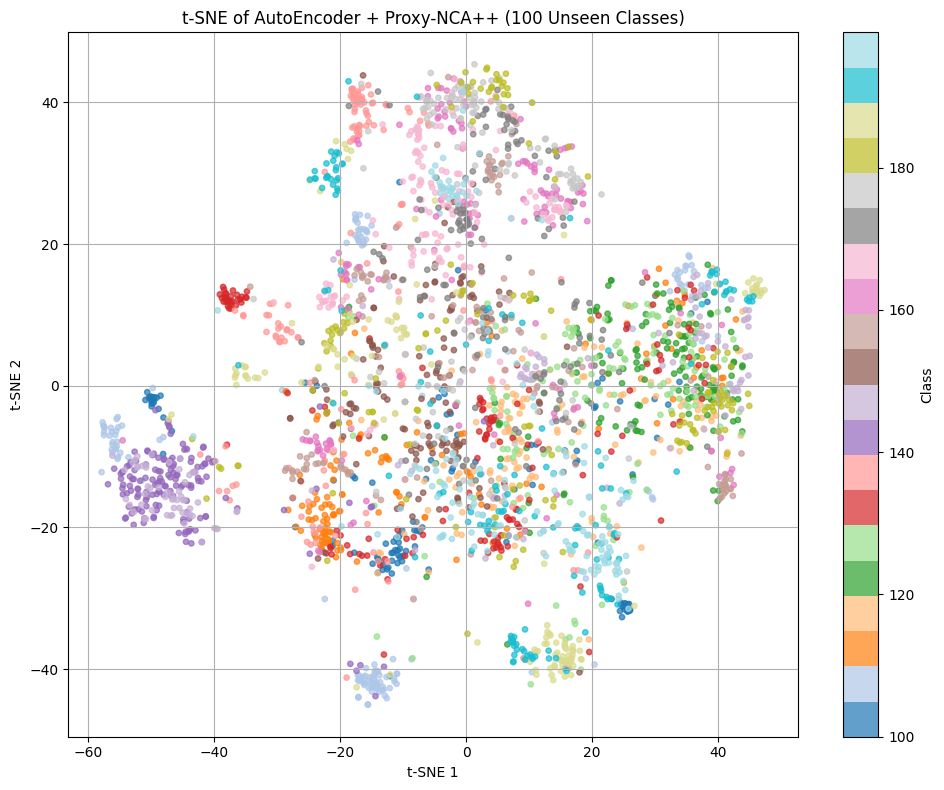

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne(E, L, title="t-SNE", n_samples=3000, perplexity=30, random_state=42):
    """
    Visualise embeddings E with labels L using t-SNE.
    
    Parameters
    ----------
    E : np.ndarray, shape (N, D)
        Embedding matrix.
    L : np.ndarray, shape (N,)
        Integer class labels.
    title : str
        Plot title.
    n_samples : int
        If N > n_samples, randomly subsample.
    perplexity : float
        t-SNE perplexity (typical values 5-50).
    random_state : int
        For reproducibility.
    """
    if len(E) > n_samples:
        idx = np.random.choice(len(E), n_samples, replace=False)
        E, L = E[idx], L[idx]

    # t-SNE (Barnes-Hut, O(N log N))
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        n_iter=1000,
        random_state=random_state,
        method='barnes_hut',   # fast approximate version
        n_jobs=-1
    )
    X_2d = tsne.fit_transform(E)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        X_2d[:, 0], X_2d[:, 1],
        c=L, cmap='tab20', s=15, alpha=0.7
    )
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.colorbar(scatter, label='Class')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# Example usage (exactly like your PCA call)
# ------------------------------------------------------------------
plot_tsne(
    test_E, test_L,
    title="t-SNE of AutoEncoder + Proxy-NCA++ (100 Unseen Classes)",
    n_samples=3000,
    perplexity=40          # tweak 20-50 for 100 classes
)